# KH-5 ARGON images interior orientation parameters retrieval and storage

In [1]:
import os
import posixpath
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import json

# parallel computing
from dask.distributed import Client

# personnal packages
import geometry.internal_orientation as gio
import optim.internal_orientation as oio

List of available KH-5 ARGON images:

In [2]:
images_root = 'D:/OneDrive/Documents/Cours/4A/SFE/data/KH-5_ARGON_images'
products = []

for x in os.listdir(images_root):
    if os.path.isdir(posixpath.join(images_root, x)):
        products.append(x)
        
products

['DS09034A007MC018',
 'DS09034A007MC019',
 'DS09034A008MC019',
 'DS09034A008MC020',
 'DS09034A008MC021',
 'DS09034A008MC022',
 'DS09058A024MC012',
 'DS09058A024MC013']

Initialise `.json` file containing all the internal orientation parameters:

In [3]:
if os.path.exists(posixpath.join(images_root, "images_params.json")) == False:
    all_params = {
        "description": "Internal and external orientation parameters for KH-5 ARGON images"
    }
    with open(posixpath.join(images_root, "images_params.json"), "w") as f:
        json.dump(all_params, f, indent=4)

Set up Dask client to prevent full rasters loading in memory:

In [4]:
def set_env():
    os.environ["GS_NO_SIGN_REQUEST"] = "YES"

set_env()

client = Client(n_workers=1, threads_per_worker=4)
client.run(set_env)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 7.89 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42896,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42904,Total threads: 4
Dashboard: http://127.0.0.1:42905/status,Memory: 7.89 GiB
Nanny: tcp://127.0.0.1:42899,


## DS09058A024MC012

Load raster and extract shape

In [5]:
img_name = "DS09058A024MC012"
file = posixpath.join(images_root, img_name, img_name + "_a.tif")
raster = rioxarray.open_rasterio(file, chunks=True)
shx, shy = raster.shape[1:]
raster

c:\ProgramData\miniconda3\Lib\site-packages\rioxarray\_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.DataArray (band: 1, y: 19912, x: 19332)> Size: 385MB
dask.array<open_rasterio-31a72a210d3b797622536cdec8c74bb8<this-array>, shape=(1, 19912, 19332), dtype=uint8, chunksize=(1, 6942, 19332), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 155kB 0.5 1.5 2.5 ... 1.933e+04 1.933e+04 1.933e+04
  * y            (y) float64 159kB 0.5 1.5 2.5 ... 1.991e+04 1.991e+04 1.991e+04
    spatial_ref  int32 4B 0
Attributes: (12/13)
    TIFFTAG_SOFTWARE:          Adobe Photoshop CC 2018 (Windows)
    TIFFTAG_DATETIME:          2019:12:03 22:08:29
    TIFFTAG_XRESOLUTION:       1432.3507
    TIFFTAG_YRESOLUTION:       1432.3507
    TIFFTAG_RESOLUTIONUNIT:    3 (pixels/cm)
    STATISTICS_APPROXIMATE:    YES
    ...                        ...
    STATISTICS_MEAN:           118.38313472809
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         96.612358145086
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0

Extract fiducial marks locations in image and fiducial coordinates:

In [6]:
SIZE_FILM = 127e-3
FMs = pd.DataFrame(
    [
        # top left corner
        [1014, 332],
        # left side
        [1027, 3220],
        [1025, 6104],
        [1025, 9000],
        [1018, 11878],
        [1020, 14768],
        # bottom left corner
        [1026, 17654],
        # bottom side
        [3904, 17662],
        [6782, 17655],
        [9673, 17661],
        [12549, 17669],
        [15435, 17668],
        # bottom right corner
        [18340, 17672],
        # right side
        [18320, 14780],
        [18327, 11892],
        [18335, 8997],
        [18335, 6125],
        [18336, 3240],
        # top right corner
        [18320, 348],
        # top side
        [15453, 343],
        [12570, 339],
        [9675, 340],
        # missing point here
        [3922, 334],
    ],
    columns = ['x', 'y'],
    index=list(range(1, 23)) + [24] # missing mark on the N side
)

FMs.loc[1, "side"] = "NW"
FMs.loc[2:6, "side"] = "W"
FMs.loc[7, "side"] = "SW"
FMs.loc[8:12, "side"] = "S"
FMs.loc[13, "side"] = "SE"
FMs.loc[14:18, "side"] = "E"
FMs.loc[19, "side"] = "NE"
FMs.loc[20:24, "side"] = "N"

# cast as float
FMs = FMs.astype({"x": float, "y": float})

xiW = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("W")), "x"].mean() * SIZE_FILM/shx
etaS = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("S")), "y"].mean() * SIZE_FILM/shy
xiE = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("E")), "x"].mean() * SIZE_FILM/shx
etaN = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("N")), "y"].mean() * SIZE_FILM/shy

FMs.loc[FMs["side"].apply(lambda x: x.__contains__("W")), "xi"] = xiW
FMs.loc[FMs["side"].apply(lambda x: x.__contains__("S")), "eta"] = etaS
FMs.loc[FMs["side"].apply(lambda x: x.__contains__("E")), "xi"] = xiE
FMs.loc[FMs["side"].apply(lambda x: x.__contains__("N")), "eta"] = etaN

delta_xi = (SIZE_FILM - xiW - (SIZE_FILM - xiE)) / 6
delta_eta = (SIZE_FILM - etaN - (SIZE_FILM - etaS)) /6

# FMs.loc[2:6, "eta"] = FMs.loc[2:6, "y"] * 127 / shy
# FMs.loc[8:12, "xi"] = FMs.loc[8:12, "x"] * 127 / shx
# FMs.loc[14:18, "eta"] = FMs.loc[14:18, "y"] * 127 / shy
# FMs.loc[20:24, "xi"] = FMs.loc[20:24, "x"] * 127 / shx

FMs.loc[2:6, "eta"] = etaN + delta_eta * np.array(range(1, 6))
FMs.loc[8:12, "xi"] = xiW + delta_xi * np.array(range(1, 6))
FMs.loc[14:18, "eta"] = etaN + delta_eta * np.array(range(5, 0, -1))
FMs.loc[20:24, "xi"] = xiW + delta_xi * np.array([5, 4, 3, 1]) # missing point here

FMs.head()

,x,y,side,xi,eta
1,1014.0,332.0,NW,0.006519,0.002229
2,1027.0,3220.0,W,0.006519,0.021197
3,1025.0,6104.0,W,0.006519,0.040165
4,1025.0,9000.0,W,0.006519,0.059132
5,1018.0,11878.0,W,0.006519,0.078100


Text(0.5, 1.0, 'Fiducial coordinates [mm]')

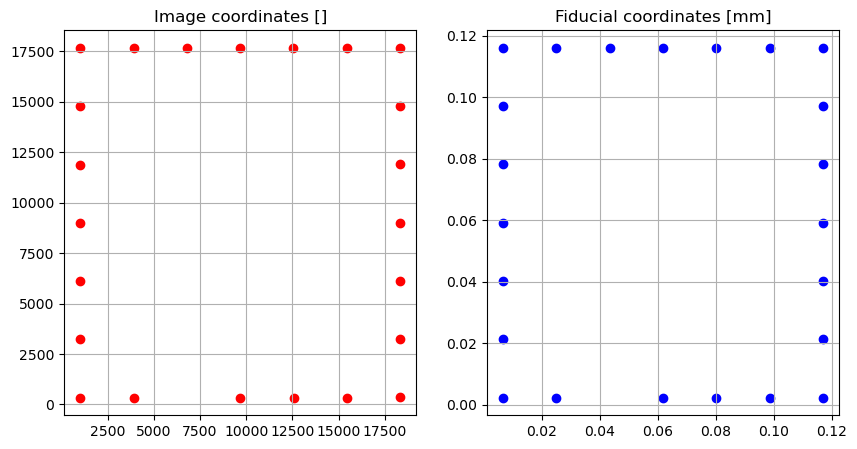

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].scatter(FMs.x, FMs.y, color='r')
axs[0].grid()
axs[0].set_title('Image coordinates []')
axs[1].scatter(FMs.xi, FMs.eta, color='b')
axs[1].grid()
axs[1].set_title('Fiducial coordinates [mm]')

Least squares regression to retrieve internal orientation parameters:

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.823747323285883e-08
             x: [-2.973e-04 -7.308e-05  3.762e-04  6.377e-06  6.571e-06]
           nit: 39
          nfev: 79
 final_simplex: (array([[-2.973e-04, -7.308e-05, ...,  6.377e-06,
                         6.571e-06],
                       [-2.431e-04, -3.079e-05, ...,  6.377e-06,
                         6.571e-06],
                       ...,
                       [-3.028e-04, -7.517e-05, ...,  6.377e-06,
                         6.571e-06],
                       [-3.019e-04, -5.139e-05, ...,  6.377e-06,
                         6.571e-06]]), array([ 3.824e-08,  3.824e-08,  3.825e-08,  3.825e-08,
                        3.825e-08,  3.825e-08]))
----------------------------------------------
|  xc  |  yc  | alpha | delta_eta * 1e5| delta_xi * 1e5|
| 0.00 | 0.00 | 0.00 | 0.64 | 0.66 |
| -0.00 | -0.00 | 0.00 | 0.64 | 0.66 |
-----------------------------------

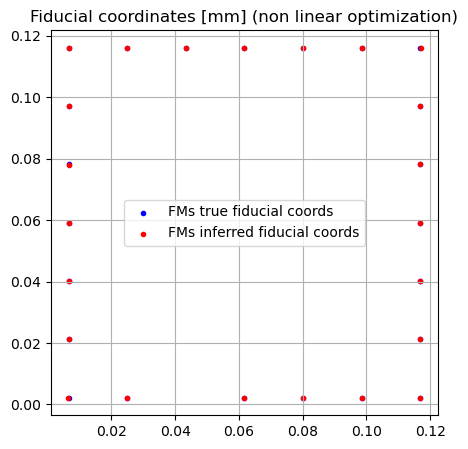

In [8]:
# res = opt.least_squares(
#     oio.objective_function,
#     x0=[0, 0, 0, 127/shx, 127/shy],
#     args=(FMs.loc[:, ("xi", "eta")].to_numpy(), FMs.loc[:, ("x", "y")].to_numpy()),
#     method="trf",
#     # x_scale="jac",
#     max_nfev=1000
# )
res = opt.minimize(
    oio.objective_function,
    x0=[0, 0, 0, SIZE_FILM/shx, SIZE_FILM/shy],
    args=(FMs.loc[:, ("xi", "eta")].to_numpy(), FMs.loc[:, ("x", "y")].to_numpy()),
    method="Nelder-mead",
    options={"maxiter": 1000},
)
print(res)

if res.success:
    params = res.x

    xc, yc, alpha, delta_eta, delta_xi = params[0], params[1], params[2], params[3], params[4]
    print("----------------------------------------------")
    print("|  xc  |  yc  | alpha | delta_eta * 1e5| delta_xi * 1e5|") 
    print("| {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} |".format(0., 0., 0., (SIZE_FILM*1e5)/shx, (SIZE_FILM*1e5)/shy)) 
    print("| {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} |".format(xc, yc, alpha, (delta_eta*1e5), (delta_xi*1e5)))
    print("----------------------------------------------")

    
    xi, eta = gio.image_to_fiducial_coordinates(FMs.loc[:, "x"].values, FMs.loc[:, "y"].values, xc, yc, alpha, delta_eta, delta_xi)
    FMs_inferred_fiducial_coords = np.array([xi, eta]).T
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(FMs.xi, FMs.eta, marker=".", color="b", label='FMs true fiducial coords')
    ax.scatter(FMs_inferred_fiducial_coords[:, 0], FMs_inferred_fiducial_coords[:, 1], marker=".", color="r", label='FMs inferred fiducial coords')
    ax.grid()
    ax.legend()
    ax.set_title("Fiducial coordinates [mm] (non linear optimization)")

Export to full `.json` file:

In [9]:
with open(posixpath.join(images_root, "images_params.json"), "r") as f:
    all_params = json.load(open(f.name, "r"))
with open(posixpath.join(images_root, "images_params.json"), "w") as f:
    if img_name not in all_params: 
        all_params[img_name] = {}
    all_params[img_name].update({
        "internal_orientation":{
            "xc": params[0],
            "yc": params[1], 
            "alpha": params[2], 
            "delta_eta": params[3], 
            "delta_xi": params[4]
        }
    })
    json.dump(all_params, f, indent=4)

## DS09058A024MC013

In [10]:
img_name = "DS09058A024MC013"
file = posixpath.join(images_root, img_name, img_name + "_a.tif")
raster = rioxarray.open_rasterio(file, chunks=True)
shx, shy = raster.shape[1:]
raster

c:\ProgramData\miniconda3\Lib\site-packages\rioxarray\_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.DataArray (band: 1, y: 19912, x: 19332)> Size: 385MB
dask.array<open_rasterio-890b347c846d082a08279604c8a0b0f9<this-array>, shape=(1, 19912, 19332), dtype=uint8, chunksize=(1, 6942, 19332), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 155kB 0.5 1.5 2.5 ... 1.933e+04 1.933e+04 1.933e+04
  * y            (y) float64 159kB 0.5 1.5 2.5 ... 1.991e+04 1.991e+04 1.991e+04
    spatial_ref  int32 4B 0
Attributes: (12/13)
    TIFFTAG_SOFTWARE:          Adobe Photoshop CC 2018 (Windows)
    TIFFTAG_DATETIME:          2019:12:03 22:13:38
    TIFFTAG_XRESOLUTION:       1432.3507
    TIFFTAG_YRESOLUTION:       1432.3507
    TIFFTAG_RESOLUTIONUNIT:    3 (pixels/cm)
    STATISTICS_APPROXIMATE:    YES
    ...                        ...
    STATISTICS_MEAN:           115.70980174446
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         99.755916419582
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0

In [11]:
FMs = pd.DataFrame(
    [
        # top left corner
        [989, 375],
        # left side
        [1005, 3263],
        [1004, 6147],
        [1006, 9043],
        [1000, 11921],
        [1004, 14811],
        # bottom left corner
        [1012, 17698],
        # bottom side
        [3890, 17703],
        [6768, 17694],
        [9659, 17698],
        [12534, 17704],
        [15420, 17701],
        # bottom right corner
        [18326, 17704],
        # right side
        [18304, 14812],
        [18309, 11924],
        [18315, 9030],
        [18313, 6157],
        [18313, 3273],
        # top right corner
        [18293, 381],
        # top side
        [15427, 378],
        [12544, 376],
        [9650, 378],
        # missing point here
        [3897, 375],
    ],
    columns = ['x', 'y'],
    index=list(range(1, 23)) + [24] # missing mark on the N side
)

FMs.loc[1, "side"] = "NW"
FMs.loc[2:6, "side"] = "W"
FMs.loc[7, "side"] = "SW"
FMs.loc[8:12, "side"] = "S"
FMs.loc[13, "side"] = "SE"
FMs.loc[14:18, "side"] = "E"
FMs.loc[19, "side"] = "NE"
FMs.loc[20:24, "side"] = "N"

# cast as float
FMs = FMs.astype({"x": float, "y": float})

xiW = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("W")), "x"].mean() * SIZE_FILM/shx
etaS = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("S")), "y"].mean() * SIZE_FILM/shy
xiE = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("E")), "x"].mean() * SIZE_FILM/shx
etaN = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("N")), "y"].mean() * SIZE_FILM/shy

FMs.loc[FMs["side"].apply(lambda x: x.__contains__("W")), "xi"] = xiW
FMs.loc[FMs["side"].apply(lambda x: x.__contains__("S")), "eta"] = etaS
FMs.loc[FMs["side"].apply(lambda x: x.__contains__("E")), "xi"] = xiE
FMs.loc[FMs["side"].apply(lambda x: x.__contains__("N")), "eta"] = etaN

delta_xi = (SIZE_FILM - xiW - (SIZE_FILM - xiE)) / 6
delta_eta = (SIZE_FILM - etaN - (SIZE_FILM - etaS)) /6

# FMs.loc[2:6, "eta"] = FMs.loc[2:6, "y"] * 127 / shy
# FMs.loc[8:12, "xi"] = FMs.loc[8:12, "x"] * 127 / shx
# FMs.loc[14:18, "eta"] = FMs.loc[14:18, "y"] * 127 / shy
# FMs.loc[20:24, "xi"] = FMs.loc[20:24, "x"] * 127 / shx

FMs.loc[2:6, "eta"] = etaN + delta_eta * np.array(range(1, 6))
FMs.loc[8:12, "xi"] = xiW + delta_xi * np.array(range(1, 6))
FMs.loc[14:18, "eta"] = etaN + delta_eta * np.array(range(5, 0, -1))
FMs.loc[20:24, "xi"] = xiW + delta_xi * np.array([5, 4, 3, 1]) # missing point here

FMs.head()

,x,y,side,xi,eta
1,989.0,375.0,NW,0.006396,0.002478
2,1005.0,3263.0,W,0.006396,0.021445
3,1004.0,6147.0,W,0.006396,0.040412
4,1006.0,9043.0,W,0.006396,0.059379
5,1000.0,11921.0,W,0.006396,0.078346


Text(0.5, 1.0, 'Fiducial coordinates [mm]')

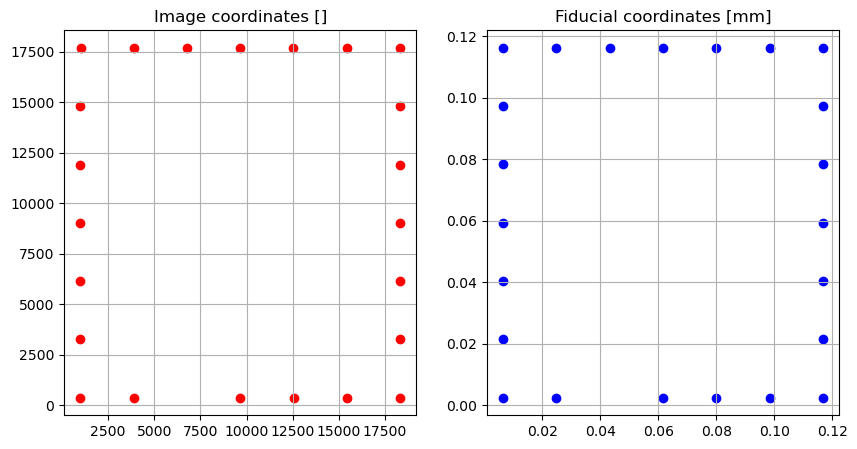

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].scatter(FMs.x, FMs.y, color='r')
axs[0].grid()
axs[0].set_title('Image coordinates []')
axs[1].scatter(FMs.xi, FMs.eta, color='b')
axs[1].grid()
axs[1].set_title('Fiducial coordinates [mm]')

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 3.200e-08]
           x: [ 0.000e+00  0.000e+00  0.000e+00  6.378e-06  6.569e-06]
        cost: 5.1192748693417125e-16
         jac: [[ 2.188e-10  2.703e-10  8.723e-07  2.443e+01  2.276e+01]]
        grad: [ 7.002e-18  8.648e-18  2.791e-14  7.818e-07  7.282e-07]
  optimality: 7.818144022702823e-07
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
        nfev: 16
        njev: 1
----------------------------------------------
|  xc  |  yc  | alpha | delta_eta | delta_xi |
| 0.00 | 0.00 | 0.00 | 0.64 | 0.66 |
| 0.00 | 0.00 | 0.00 | 0.64 | 0.66 |
----------------------------------------------


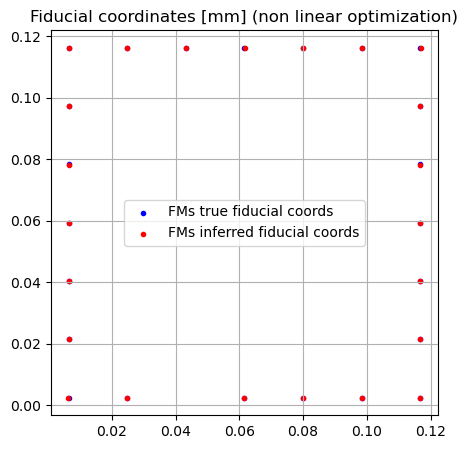

In [13]:
res = opt.least_squares(
    oio.objective_function,
    x0=[0, 0, 0, SIZE_FILM/shx, SIZE_FILM/shy],
    args=(FMs.loc[:, ("xi", "eta")].to_numpy(), FMs.loc[:, ("x", "y")].to_numpy()),
    method="trf",
    # x_scale="jac",
    max_nfev=1000
)
# res = opt.minimize(
#     oio.objective_function,
#     x0=[0, 0, 0, 127/shx, 127/shy],
#     args=(FMs.loc[:, ("xi", "eta")].to_numpy(), FMs.loc[:, ("x", "y")].to_numpy()),
#     method="Nelder-mead",
#     options={"maxiter": 1000},
# )
print(res)

if res.success:
    params = res.x

    xc, yc, alpha, delta_eta, delta_xi = params[0], params[1], params[2], params[3], params[4]
    print("----------------------------------------------")
    print("|  xc  |  yc  | alpha | delta_eta | delta_xi |") 
    print("| {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} |".format(0., 0., 0., (SIZE_FILM * 1e5)/shx, (SIZE_FILM * 1e5)/shy)) 
    print("| {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} |".format(xc, yc, alpha, (delta_eta * 1e5), (delta_xi * 1e5)))
    print("----------------------------------------------")

    
    xi, eta = gio.image_to_fiducial_coordinates(FMs.loc[:, "x"].values, FMs.loc[:, "y"].values, xc, yc, alpha, delta_eta, delta_xi)
    FMs_inferred_fiducial_coords = np.array([xi, eta]).T
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(FMs.xi, FMs.eta, marker=".", color="b", label='FMs true fiducial coords')
    ax.scatter(FMs_inferred_fiducial_coords[:, 0], FMs_inferred_fiducial_coords[:, 1], marker=".", color="r", label='FMs inferred fiducial coords')
    ax.grid()
    ax.legend()
    ax.set_title("Fiducial coordinates [mm] (non linear optimization)")

In [14]:
with open(posixpath.join(images_root, "images_params.json"), "r") as f:
    all_params = json.load(open(f.name, "r"))
with open(posixpath.join(images_root, "images_params.json"), "w") as f:
    if img_name not in all_params: 
        all_params[img_name] = {}
    all_params[img_name].update({
        "internal_orientation":{
            "xc": params[0],
            "yc": params[1], 
            "alpha": params[2], 
            "delta_eta": params[3], 
            "delta_xi": params[4]
        }
    })
    json.dump(all_params, f, indent=4)